# PaddleOCR を SageMaker にデプロイする

## 1. コンテナイメージを作成する

ここにあるサンプルスクリプトを参考にして作成します。

https://github.com/aws/amazon-sagemaker-examples/tree/master/advanced_functionality/multi_model_bring_your_own


### 1.1 領域の確保

まずコンテナイメージ作成に必要な領域をホームディレクトリに確保し、ここでビルドに必要なものを保存するようにします。

In [22]:
!sudo /etc/init.d/docker stop
!mkdir /home/ec2-user/SageMaker/docker/
!sudo mv /var/lib/docker /home/ec2-user/SageMaker/docker
!sudo ln -s /home/ec2-user/SageMaker/docker /var/lib/docker
!sudo /etc/init.d/docker start

Stopping docker: [  OK  ]
Starting docker:	.[  OK  ]


### 1.2 Dockerfile の作成

GPU を利用できるようにするために cuda10.2 を利用できるイメージを使います。また、PIP で paddleOCR を python から実行できるようにライブラリをインストールします。以下のセルを実行すると必要な Dockerfile が ./container に保存されます。

- RUN pip3 install paddlepaddle-gpu==2.0.2
- RUN pip3 install "paddleocr>=2.0.1" 

In [36]:
%%writefile ./container/Dockerfile
# PaddleOCR requires glibc 2.2.3 installed in ubuntu16.04
# and cuda10.2 for using GPU
FROM nvidia/cuda:10.2-cudnn7-devel-ubuntu16.04
    
# Set a docker label to advertise multi-model support on the container
LABEL com.amazonaws.sagemaker.capabilities.multi-models=true
# Set a docker label to enable container to use SAGEMAKER_BIND_TO_PORT environment variable if present
LABEL com.amazonaws.sagemaker.capabilities.accept-bind-to-port=true

ARG PYTHON_VERSION=3.7.10
ARG MMS_VERSION=1.0.8

# See http://bugs.python.org/issue19846
ENV LANG C.UTF-8
ENV LD_LIBRARY_PATH /opt/conda/lib/:$LD_LIBRARY_PATH
ENV PATH /opt/conda/bin:$PATH


RUN apt-get update && apt-get install -y --no-install-recommends \
    build-essential \
    ca-certificates \
    cmake \
    curl \
    git \
    jq \
    libgl1-mesa-glx \
    libglib2.0-0 \
    libsm6 \
    libxext6 \
    libxrender-dev \
    openjdk-8-jdk-headless \
    vim \
    wget \
    zlib1g-dev

RUN curl -L -o ~/miniconda.sh https://repo.continuum.io/miniconda/Miniconda3-latest-Linux-x86_64.sh \
 && chmod +x ~/miniconda.sh \
 && ~/miniconda.sh -b -p /opt/conda \
 && rm ~/miniconda.sh \
 && /opt/conda/bin/conda update conda \
 && /opt/conda/bin/conda install -y \
    python=$PYTHON_VERSION \
    cython==0.29.12 \
    ipython==7.7.0 \
    mkl-include==2019.4 \
    mkl==2019.4 \
    numpy==1.16.4 \
    scipy==1.3.0 \
    typing==3.6.4 \
 && /opt/conda/bin/conda clean -ya

# install paddleocr
RUN pip3 install paddlepaddle-gpu==2.0.2
RUN pip3 install "paddleocr>=2.0.1" 

# Install MXNet, MMS, and SageMaker Inference Toolkit to set up MMS
RUN pip3 --no-cache-dir install mxnet \
                                multi-model-server \
                                sagemaker-inference \
                                retrying



# Copy entrypoint script to the image
COPY dockerd-entrypoint.py /usr/local/bin/dockerd-entrypoint.py
RUN chmod +x /usr/local/bin/dockerd-entrypoint.py

RUN mkdir -p /home/model-server/

# Copy the default custom service file to handle incoming data and inference requests
COPY model_handler.py /home/model-server/model_handler.py

# Define an entrypoint script for the docker image
ENTRYPOINT ["python", "/usr/local/bin/dockerd-entrypoint.py"]

# Define command to be passed to the entrypoint
CMD ["serve"]


Overwriting ./container/Dockerfile


### 1.3 dockerd-entrypoint.py の作成

ここはサンプルそのままです。

In [37]:
%%writefile ./container/dockerd-entrypoint.py

import subprocess
import sys
import shlex
import os
from retrying import retry
from subprocess import CalledProcessError
from sagemaker_inference import model_server

def _retry_if_error(exception):
    return isinstance(exception, CalledProcessError or OSError)

@retry(stop_max_delay=1000 * 50,
       retry_on_exception=_retry_if_error)
def _start_mms():
    # by default the number of workers per model is 1, but we can configure it through the
    # environment variable below if desired.
    # os.environ['SAGEMAKER_MODEL_SERVER_WORKERS'] = '2'
    model_server.start_model_server(handler_service='/home/model-server/model_handler.py:handle')

def main():
    if sys.argv[1] == 'serve':
        _start_mms()
    else:
        subprocess.check_call(shlex.split(' '.join(sys.argv[1:])))

    # prevent docker exit
    subprocess.call(['tail', '-f', '/dev/null'])
    
main()


Overwriting ./container/dockerd-entrypoint.py


### 1.4 model_handler.py の作成


実際にモデルで推論する際の挙動を記述します。その挙動は、グローバルの関数の `handle(data, context)` で書かれているように

1. 初期化されていなければ initialize で初期化する (モデルをロードするなど）
1. データがくればhandleで予測した結果を返す

となっています。つまり、initialize と handle を実装すればOKです。initialize は以下のようにモデルをロードする処理を書きます。SageMaker は S3 にモデルをおいておけば、それを /opt/ml/model/ においてくれますので、そこに置かれた各種モデルを読むようにします。S3へのモデル配置はこのあと行います。


In [38]:
%%writefile ./container/model_handler.py

"""
ModelHandler defines an example model handler for load and inference requests for MXNet CPU models
"""
from collections import namedtuple
import json
import logging
import os
import re

import mxnet as mx
import numpy as np
from io import BytesIO
from paddleocr import PaddleOCR, draw_ocr
from glob import glob
from PIL import Image
import base64

class ModelHandler(object):
    """
    A sample Model handler implementation.
    """

    def __init__(self):
        self.initialized = False
        self.ocr = None

    def initialize(self, context):
        """
        Initialize model. This will be called during model loading time
        :param context: Initial context contains model server system properties.
        :return:
        """
        self.initialized = True
        model_dir = "/opt/ml/model/"
        
        # Load ocr model
        try:
            self.ocr = PaddleOCR(det_model_dir=os.path.join(model_dir,'model/det'),
            rec_model_dir=os.path.join(model_dir,'model/rec/ja'),
            rec_char_dict_path=os.path.join(model_dir,'model/dict/japan_dict.txt'),
            cls_model_dir=os.path.join(model_dir,'model/cls'), 
            use_angle_cls=True, lang="japan", use_gpu=True)
              
        except Exception as e:
            raise
            
    def preprocess(self, request):
        """
        Transform raw input into model input data.
        :param request: list of raw requests
        :return: list of preprocessed model input data
        """
        # Take the input data and pre-process it make it inference ready

        img_list = []
        for idx, data in enumerate(request):
            # Read the bytearray of the image from the input
            img_arr = data.get('body')
            img_arr = base64.b64decode(img_arr)
            img_arr = Image.open(BytesIO(img_arr))
            img_arr = np.array(img_arr)
            
            # Check the number of dimension
            assert len(img_arr.shape) == 3, "Dimension must be 3, but {}".format(len(img_arr.shape)) 

            img_list.append(img_arr)

        return img_list

    def inference(self, model_input):
        """
        Internal inference methods
        :param model_input: transformed model input data list
        :return: list of inference output 
        """
        res_list = []
        # Do some inference call to engine here and return output
        for img in model_input:
            result = self.ocr.ocr(img, cls=True)
            for res in result:
                ## because float32 is not json serializable, score is converted to float (float64)
                ## However the score is in tuple and cannot be replaced. The entire tupple is replaced as list.
                string = res[1][0]
                score = float(res[1][1])
                res[1] = [string,score]

            res_list.append(result)
        return res_list
        
    def handle(self, data, context):
        """
        Call preprocess, inference and post-process functions
        :param data: input data
        :param context: mms context
        """
        
        model_input = self.preprocess(data)
        model_out = self.inference(model_input)
        return model_out

_service = ModelHandler()


def handle(data, context):
    if not _service.initialized:
        _service.initialize(context)

    if data is None:
        return None

    return _service.handle(data, context)


Overwriting ./container/model_handler.py


### 1.5 コンテナイメージをビルドして ECR に push する

ここもサンプルと同じように実行します。`algorithm_name` は好きなものを指定しましょう。  
`algorithm_name=paddleocr-gpu`であれば、以下が ECR 上での URI になります。
```
(アカウントID).dkr.ecr.(リージョン名).amazonaws.com/paddleocr-gpu:latest 
```

In [ ]:
%%sh

# The name of our algorithm
algorithm_name=paddleocr-gpu

cd container

account=$(aws sts get-caller-identity --query Account --output text)

# Get the region defined in the current configuration (default to us-west-2 if none defined)
region=$(aws configure get region)
region=${region:-us-west-2}

fullname="${account}.dkr.ecr.${region}.amazonaws.com/${algorithm_name}:latest"

# If the repository doesn't exist in ECR, create it.
aws ecr describe-repositories --repository-names "${algorithm_name}" > /dev/null 2>&1

if [ $? -ne 0 ]
then
    aws ecr create-repository --repository-name "${algorithm_name}" > /dev/null
fi

# Get the login command from ECR and execute it directly
$(aws ecr get-login --region ${region} --no-include-email)

docker build -q -t ${algorithm_name} .
docker tag ${algorithm_name} ${fullname}

docker push ${fullname}

## 1.6 URI のメモ

先ほどの命名規則 `(アカウントID).dkr.ecr.(リージョン名).amazonaws.com/paddleocr-gpu:latest` に沿って URI を作成・メモし、後で使えるよう `image_uri` に保存します。

In [ ]:
import boto3

account_id = boto3.client('sts').get_caller_identity().get('Account')
region = boto3.session.Session().region_name 
image_uri = str(account_id) + ".dkr.ecr." +  region + ".amazonaws.com/paddleocr-gpu:latest"

print(image_uri)

## 2. コンテナイメージを使って OCR モデルをデプロイ

### 2.1. モデルのダウンロード・圧縮・S3へのアップロード


PaddleOCR のライブラリは、モデルがローカルにない場合は自動でモデルをダウンロードする仕組みをもっています。しかし今回は、事前にモデルをダウンロードして S3 に保存しておき、デプロイするときは S3 からモデルをダウンロードして利用するようにします。自分で管理するので手間ではありますが、もしライブラリがモデルのダウンロードに失敗しても S3 からダウンロードして対応できます。

以下のテキストエリア検出、テキスト認識（認識モデルと日本語辞書）、テキスト分類（角度調整等に利用）の4つのファイルがあり、それぞれダウンロード・解凍して、以下に示すフォルダ構造で保存します。このフォルダ構造は、コンテナイメージをビルドする際に作成した `model_handler.py` の関数 `initialize` でモデルを読み込む際の階層構造と合わせる必要があります。また、モデルの URL は[こちらのファイル](https://github.com/PaddlePaddle/PaddleOCR/blob/release/2.1/paddleocr.py)から確認できます。テキスト認識にかかる2つのファイルは言語固有で、それ以外は、各言語共通のものを使います。

以下の階層構造でモデルなどを保存したら、それらを1つに圧縮して `model.tar.gz` にします。これは SageMaker が tar.gz で圧縮されていることを前提とするためです。エンドポイントを作成する際は、この`model.tar.gz`は解凍されて `/opt/ml/model` に展開されます（つまり /opt/ml/model/model/det/ 以下にテキストエリア検出モデルが展開されます）。

```
model
├── det       ... (テキストエリア検出)
├── rec
│　　 └── ja   ... (テキスト認識モデル)
├── dict      ... (日本語辞書)
└── cls       ... (テキスト分類)
```

In [ ]:
!mkdir -p model/det
!mkdir -p model/rec/ja
!mkdir -p model/dict
!mkdir -p model/cls

!wget https://paddleocr.bj.bcebos.com/dygraph_v2.0/multilingual/en_ppocr_mobile_v2.0_det_infer.tar -O model/det/en_ppocr_mobile_v2.0_det_infer.tar
!cd model/det/ && tar xvf en_ppocr_mobile_v2.0_det_infer.tar --strip-components 1 && rm en_ppocr_mobile_v2.0_det_infer.tar

!wget https://paddleocr.bj.bcebos.com/dygraph_v2.0/multilingual/japan_mobile_v2.0_rec_infer.tar -O model/rec/ja/japan_mobile_v2.0_rec_infer.tar
!cd model/rec/ja/ && tar xvf japan_mobile_v2.0_rec_infer.tar --strip-components 1 && rm japan_mobile_v2.0_rec_infer.tar

!wget https://paddleocr.bj.bcebos.com/dygraph_v2.0/ch/ch_ppocr_mobile_v2.0_cls_infer.tar -O model/cls/ch_ppocr_mobile_v2.0_cls_infer.tar
!cd model/cls/ && tar xvf ch_ppocr_mobile_v2.0_cls_infer.tar --strip-components 1 && rm ch_ppocr_mobile_v2.0_cls_infer.tar

!wget https://raw.githubusercontent.com/PaddlePaddle/PaddleOCR/release/2.0/ppocr/utils/dict/japan_dict.txt -O ./model/dict/japan_dict.txt
    
!tar -zcvf model.tar.gz model

In [ ]:
import sagemaker 

model_uri = sagemaker.Session().upload_data("model.tar.gz", key_prefix="ocr_model")

### 2.2. デプロイ

SageMaker の Model を作成して deploy を実行すればエンドポイントを作成できます。`image_uri`には ECR に push したコンテナイメージの URI を、`model_data` には先ほどアップロードした OCR モデル (model.tar.gz) へのパスを渡します。

In [ ]:
from sagemaker.model import Model
from sagemaker.predictor import Predictor

ocr_model = sagemaker.model.Model(image_uri,
                      model_data=model_uri, 
                      predictor_cls=Predictor,
                      role=sagemaker.get_execution_role())


今回は GPU を使いたいので `ml.g4dn.xlarge` をインスタンスに選んでデプロイします。ただし、これには時間がかかるので、もしデバッグがすんでいなければ、`instance_type="local"`と指定して、ローカル環境でまずはテストしてみましょう。以下でエラーが出る場合は、コンテナイメージに不具合があるはずなので、エラーを CloudWatch Logs で確認して、`Dockerfile` や `model_handler.py` を修正してコンテナイメージをもう一度ビルドします。


In [ ]:
predictor = ocr_model.deploy(initial_instance_count=1,instance_type="ml.g4dn.xlarge")

### 3. テスト


某所から持ってきた画像を試してみます。画像は `model_handler.py` で実装したように base64 でエンコードして送ります。

In [ ]:
%%time
import base64
from io import BytesIO
from PIL import Image
import PIL

image = Image.open("test02.png")
if isinstance(image,PIL.PngImagePlugin.PngImageFile):
    image = image.convert('RGB') 

buffered = BytesIO()
image.save(buffered, format="JPEG")
img_str = base64.b64encode(buffered.getvalue())

import json
response = json.loads(predictor.predict(img_str))



`response` には結果が入っていますが、わかりやすくするため、検出された場所に赤枠で囲み、認識されたテキストと対応付けるための通し番号を付けます。


In [124]:
import numpy as np
import cv2
x_offset = 20
y_offset = 0
for i, res in enumerate(response):
    box = np.reshape(np.array(res[0]), [-1, 1, 2]).astype(np.int64)
#     print(box)
    image = cv2.putText(np.array(image), '('+str(i)+')', (box[0][0][0] -x_offset, box[0][0][1]-y_offset), 
                        cv2.FONT_HERSHEY_PLAIN, 1, (255, 0, 0), 1, cv2.LINE_AA)
    image = cv2.polylines(np.array(image), [box], True, (255, 0, 0), 2)

(0): データ転送, (1): 以下の料金は、AmaJnＥC2に「受信 (イン)」/「送信（(アウト)」されるデータ転送量を基にしています。, (2): リージョン;, (3): 米国東部 (オハイオ）・, (4): 料金, (5): イソターネットから （ma0nEC2へのデータ転送 (イン), (6): すべてのデータ受信, (7): O 0OUSD/GB, (8): Amá20nEC2からインターネットへのデータ転送(アウト), (9): 1GB/月まで, (10): 000USD/CB, (11): 次の９,9991B/月, (12): O 09USD/GB, (13): 次の401B/月, (14):  0 085USD/GB, (15): 次の100TB/月, (16): O 07USD/GB, (17): 1501B/月以上, (18): 0 05USD/GB, 

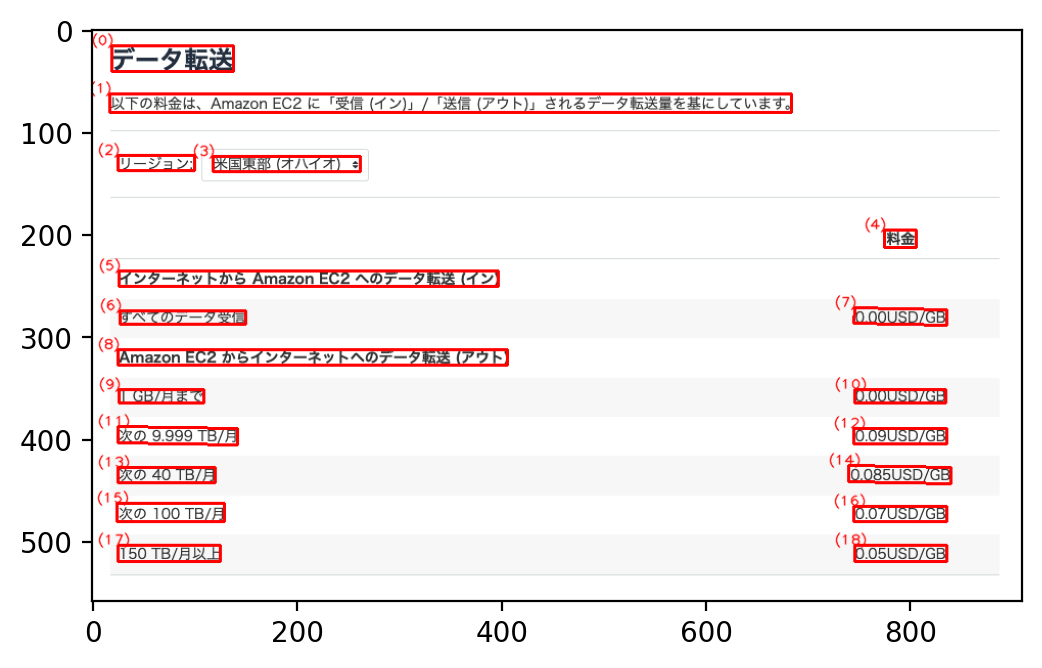

In [125]:
import matplotlib.pyplot as plt
for i,res in enumerate(response):
    print('('+str(i)+'): '+res[1][0], end=', ')
fig = plt.figure(dpi=200)
plt.imshow(image)
plt.show()

## 4. 後片付け

最後に不要なエンドポイントを削除しましょう。


In [128]:
predictor.delete_endpoint()